# Comparisons of differences in brain regions

In this work, we examine if the differences in brain regions of mice are related to genotype. That is, are some of the differences in brain regions different in APOE2, APOE3, and APOE4 genotypes? This approach contrasts to the brain volume covariance approach, but allows for graph based approaches to studying brain volumes by treating the distance matrix as a graph. For example, if two regions have positive correlation in a particular genotype, then the correlation of the differences in brain regions should also have positive correlation. Therefore, this approach allows for similar, if not the same, interpretation of the brain volume correlation methods. 

In this notebook, we will first normalize the brain volumes such that we are studying the relative brain volumes. We will then compute the differences in brain regions for all pairs of regions for each subject, resulting in a distance matrix per subject. We will then test if the differences between a specific pairs are different among the genotypes, that is compute a p-value for each pair of regions. We will then test if all the pairwise differences in brain volume corresponding to particular regions are different among the genotypes. 

In [24]:
import graspologic as gp
import hyppo
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from hyppo.ksample import MANOVA, KSample
from joblib import Parallel, delayed
from scipy.spatial.distance import pdist, squareform
from statsmodels.stats.multitest import multipletests

from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUB_STRUCTURES,
    SUPER_STRUCTURES,
    load_fa,
    load_fa_corr,
    load_vertex_df,
    load_vertex_metadata,
    load_volume,
    load_volume_corr,
)

In [2]:
vertex_df = load_vertex_df()
vols, labels = load_volume()

# normalize volumes
vols /= vols.sum(axis=1, keepdims=True)
unique_labels = np.unique(labels)

# make distance matrices
vol_dists = np.array([squareform(pdist(v.reshape(-1, 1))) for v in vols])

## Visualize the average differences between regions

We first visualize the mean distance matrix separated by genotypes. We do not observe specific patterns among the genotypes, but we see that very few select regions have significantly high differences in brain regions.

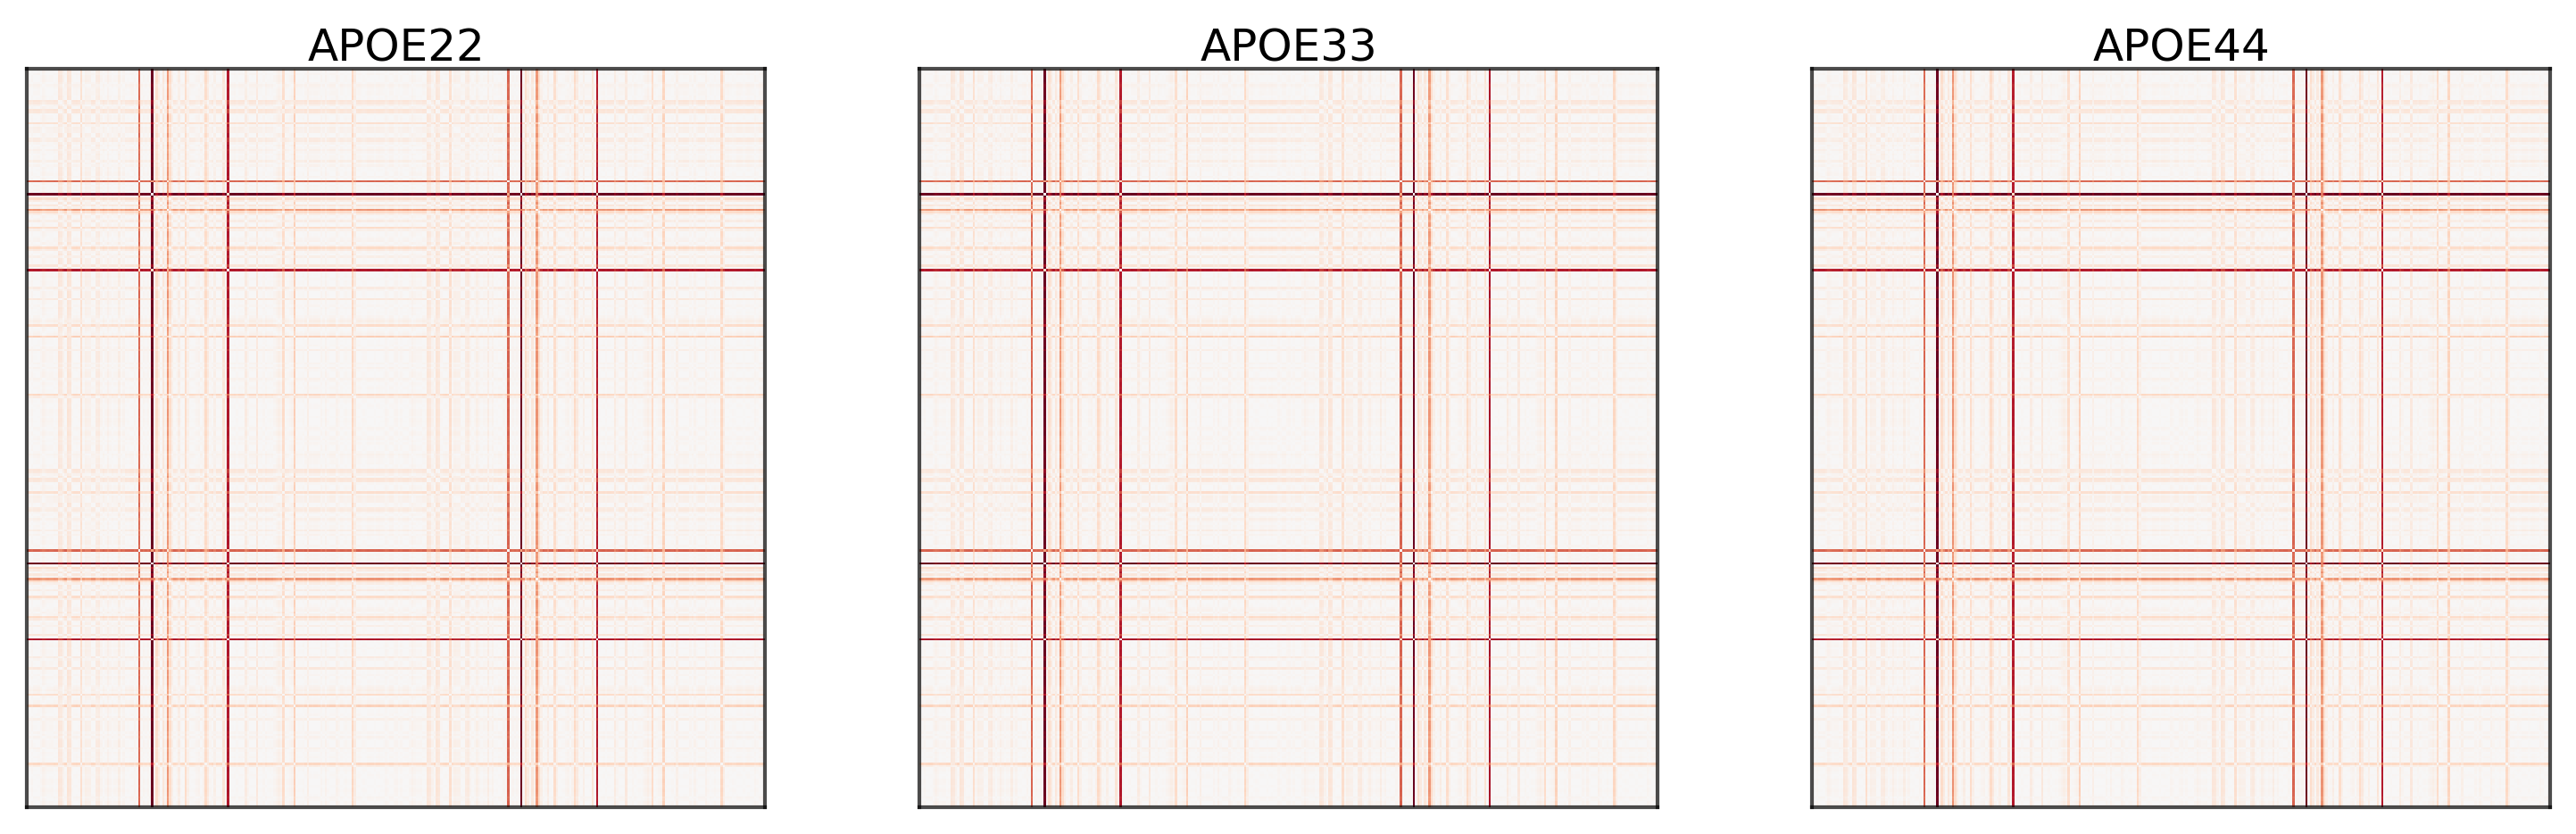

In [3]:
means = [vol_dists[labels == label].mean(axis=0) for label in np.unique(labels)]

## plot the mean differences per genotype
fig, ax = plt.subplots(
    ncols=3,
    figsize=(10, 3),
    constrained_layout=True,
    dpi=300,
    gridspec_kw=dict(width_ratios=[1, 1, 1]),
)

for idx, label in enumerate(np.unique(labels)):
    data = vol_dists[labels == label].mean(axis=0)
    gp.plot.adjplot(
        means[idx],
        ax=ax[idx],
        # meta=vertex_name,
        # group=["Hemisphere_abbrev"],
    )
    ax[idx].set_title(f"{label}", pad=0, size=12)

## Visualize the abolute differences in genotypes

Here take the absolute differences in the mean distance matrices, and visualize the resulting matrix. We now see that different pairs of genotypes show distinct patterns.

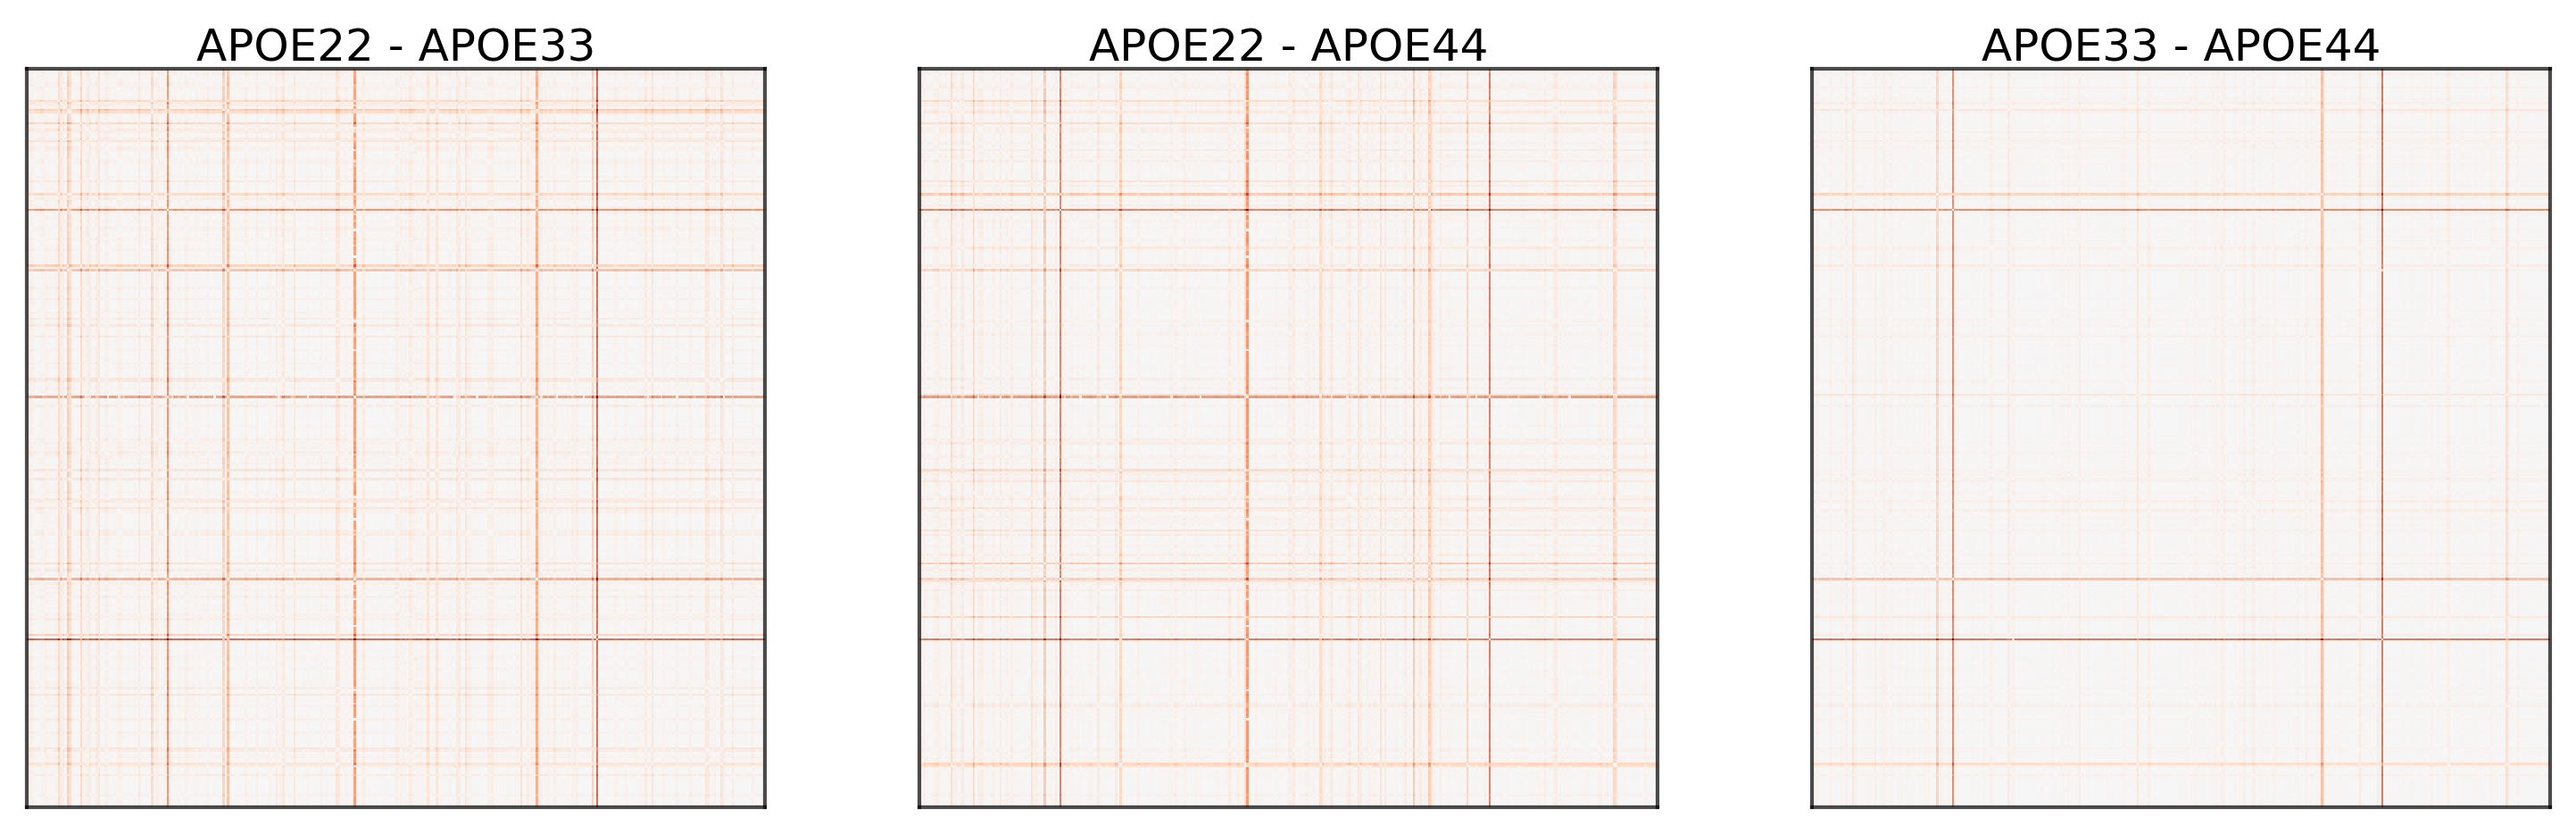

In [4]:
## plot the absolute difference in means
fig, ax = plt.subplots(
    ncols=3,
    figsize=(10, 3),
    constrained_layout=True,
    dpi=300,
    gridspec_kw=dict(width_ratios=[1, 1, 1]),
)

for idx, (label1, label2) in enumerate([(0, 1), (0, 2), (1, 2)]):
    data = np.abs(means[label1] - means[label2])
    gp.plot.adjplot(
        data,
        ax=ax[idx],
        # meta=vertex_name,
        # group=["Hemisphere_abbrev"],
    )
    ax[idx].set_title(
        f"{unique_labels[label1]} - {unique_labels[label2]}", pad=0, size=12
    )

## Edge-wise analysis of distances

Here, we examine if the distances of a particular pairs of the brain are different among the genoptyes. Let $D^{(k)}_{ij}$ denote a $332 \times 332$ distance matrix for a particular subject with genotype $k$ and $i,j$ indexing a particular element in the distance matrix. Here, we will test if the distributions of the differences between each pair of brain regions are significantly different via distance correlations. That is for each $i,j$ pair of brain regions we test:

\begin{align*}
H_0:& F_{D^{(APOE2)}_{ij}} = F_{D^{(APOE3)}_{ij}} = F_{D^{(APOE4)}_{ij}}\\
H_A:& \exists F_{D^{(k)}_{ij}} \neq F_{D^{(l)}_{ij}}
\end{align*}

where the null is that there is no differences in the distribution of  distances of brain regions, while the altnate is that there exists at least one pair of genotype is different. 

In [20]:
rdx, cdx = np.triu_indices_from(vol_dists[0], k=1)
n = rdx.size

apoe2 = vol_dists[labels == "APOE22"]
apoe3 = vol_dists[labels == "APOE33"]
apoe4 = vol_dists[labels == "APOE44"]


def worker(x, y, z, reps=50000, auto=False):
    stat, pval = KSample("Dcorr").test(x, y, z, auto=auto, reps=reps)

    return stat, pval


res = Parallel(-1, verbose=0)(
    delayed(worker)(apoe2[:, i, j], apoe3[:, i, j], apoe4[:, i, j])
    for i, j in zip(rdx, cdx)
)

In [21]:
edge_df = pd.DataFrame(res, columns=["stat", "pvalue"])

edge_df["rdx"] = rdx
edge_df["cdx"] = cdx

for idx, row in edge_df.iterrows():
    loc1 = row["rdx"]
    region1 = vertex_df.loc[loc1, ["Hemisphere", "Structure"]]

    loc2 = row["cdx"]
    region2 = vertex_df.loc[loc2, ["Hemisphere", "Structure"]]

    edge_df.loc[idx, "region1"] = "-".join(region1.values)
    edge_df.loc[idx, "region2"] = "-".join(region2.values)

significant, corrected_pvalue, _, _ = multipletests(edge_df.pvalue, method="fdr_bh")

edge_df["corrected_pvalue"] = corrected_pvalue
edge_df["significant"] = significant

edge_df = edge_df[
    ["stat", "pvalue", "corrected_pvalue", "significant", "region1", "region2"]
]
edge_df.to_csv("../outs/volume_edge.csv", index=False)

Here we list out the top 10 pairs of regions that are significantly different with the largest test statistic.

In [166]:
edge_df.sort_values(["pvalue", "stat"], ascending=[True, False]).head(10)

,stat,pvalue,corrected_pvalue,significant,region1,region2
33434,0.501310,0.0001,0.021213,True,L-Lateral_Olfactory_Tract,L-Medial_Lemniscus
33418,0.452451,0.0001,0.021213,True,L-Lateral_Olfactory_Tract,L-Ventral_Hippocampal_Commissure
50236,0.429288,0.0001,0.021213,True,R-Periaquaductal_Grey,R-Pontine_Reticular_Nucleus
18976,0.411637,0.0001,0.021213,True,L-Striatum,L-Spinocerebellar_Tract
19148,0.408775,0.0001,0.021213,True,L-Striatum,R-Cerebellar_White_Matter
33600,0.400340,0.0001,0.021213,True,L-Lateral_Olfactory_Tract,R-Medial_Lemniscus
33584,0.396358,0.0001,0.021213,True,L-Lateral_Olfactory_Tract,R-Ventral_Hippocampal_Commissure
15679,0.396218,0.0001,0.021213,True,L-Dorsal_Tenia_Tecta,L-Ventral_Hippocampal_Commissure
33711,0.391122,0.0001,0.021213,True,L-Ventral_Hippocampal_Commissure,R-Claustrum
15845,0.388886,0.0001,0.021213,True,L-Dorsal_Tenia_Tecta,R-Ventral_Hippocampal_Commissure


The total number of significant pairs of regions are 713 out of 54946 pairs.

In [167]:
edge_df.significant.sum()

713

## Vertex-wise analysis of distances

Here we examine if the distances of brain volumes are different on a region basis. That is, we test if all the pairwise differences in brain volumes corresponding to a particular regions are significantly different. Let $D^{(k)}_{i}$ denote a $332 \times 332$ distance matrix for a particular subject with genotype $k$ and $i$ indexing a particular **row** of the distance matrix. Here, we will test if the distributions of the distances corresponding to a particular brain region are significantly different via distance correlations. That is for each $i$  brain region we test:

\begin{align*}
H_0:& F_{D^{(APOE2)}_{i}} = F_{D^{(APOE3)}_{i}} = F_{D^{(APOE4)}_{i}}\\
H_A:& \exists F_{D^{(k)}_{i}} \neq F_{D^{(l)}_{i}}
\end{align*}

where the null is that there is no differences in the distribution of distances, while the altnate is that there exists at least one pair of genotype is different. 

This approach contrasts from the prior approach in Edge-wise analysis in that for each comparison, we are using all of the information given by a particular region of the brain. This allows for more reliable results because it allows for interation between all of the regions in a single comparison.

In [ ]:
res = Parallel(-1, verbose=0)(
    delayed(worker)(apoe2[:, i, :], apoe3[:, i, :], apoe4[:, i, :])
    for i in range(apoe2.shape[1])
)

region_df = pd.DataFrame(res, columns=["stat", "pvalue"])

region_df["idx"] = np.arange(apoe2.shape[1])

for idx, row in region_df.iterrows():
    loc = row["idx"]
    region = vertex_df.loc[loc, ["Hemisphere", "Structure"]]

    region_df.loc[idx, "region"] = "-".join(region.values)

region_df = region_df[["stat", "pvalue", "corrected_pvalue", "significant", "region"]]

significant, corrected_pvalue, _, _ = multipletests(region_df.pvalue, method="fdr_bh")

region_df["corrected_pvalue"] = corrected_pvalue
region_df["significant"] = significant

region_df.to_csv("../outs/volume_vertex.csv", index=False)

Here we list out the top 10 regions that are significantly different with the largest test statistic.

In [163]:
region_df.sort_values(["pvalue", "stat"], ascending=[True, False]).head(10)

,stat,pvalue,corrected_pvalue,significant,region
63,0.330623,0.000249,0.049952,True,L-Striatum
256,0.189688,0.001658,0.049952,True,R-Cerebellar_Cortex
18,0.177294,0.001907,0.049952,True,L-Primary_Motor_Cortex
168,0.138262,0.002073,0.049952,True,R-Cingulate_Cortex_Area_24b
2,0.145418,0.002653,0.049952,True,L-Cingulate_Cortex_Area_24b
28,0.139471,0.002819,0.049952,True,L-Primary_Somatosensory_Cortex_Jaw_Region
197,0.140740,0.003068,0.049952,True,R-Primary_Somatosensory_Cortex_Upper_Lip_Region
209,0.134273,0.003565,0.049952,True,R-Dorsolateral_Entorhinal_Cortex
234,0.131458,0.003565,0.049952,True,R-Periaquaductal_Grey
246,0.155338,0.003980,0.049952,True,R-Superior_Colliculus


The total number of significant regions is 259 out of 332 regions. 

In [164]:
(region_df.significant).sum()

259

# Comparisons of differences in fractional anisotropy

In these sections, we test for fractional anisotropy instead of brain volumes

In [29]:
vertex_df = load_vertex_df()
fas, labels = load_fa()

# normalize volumes
for i in range(fas.shape[0]):
    fas[i] /= fas[i].max()
unique_labels = np.unique(labels)

# make distance matrices
fa_dists = np.array([squareform(pdist(v.reshape(-1, 1))) for v in fas])

## Visualize the average differences between regions

We first visualize the mean distance matrix separated by genotypes. We do not observe specific patterns among the genotypes.

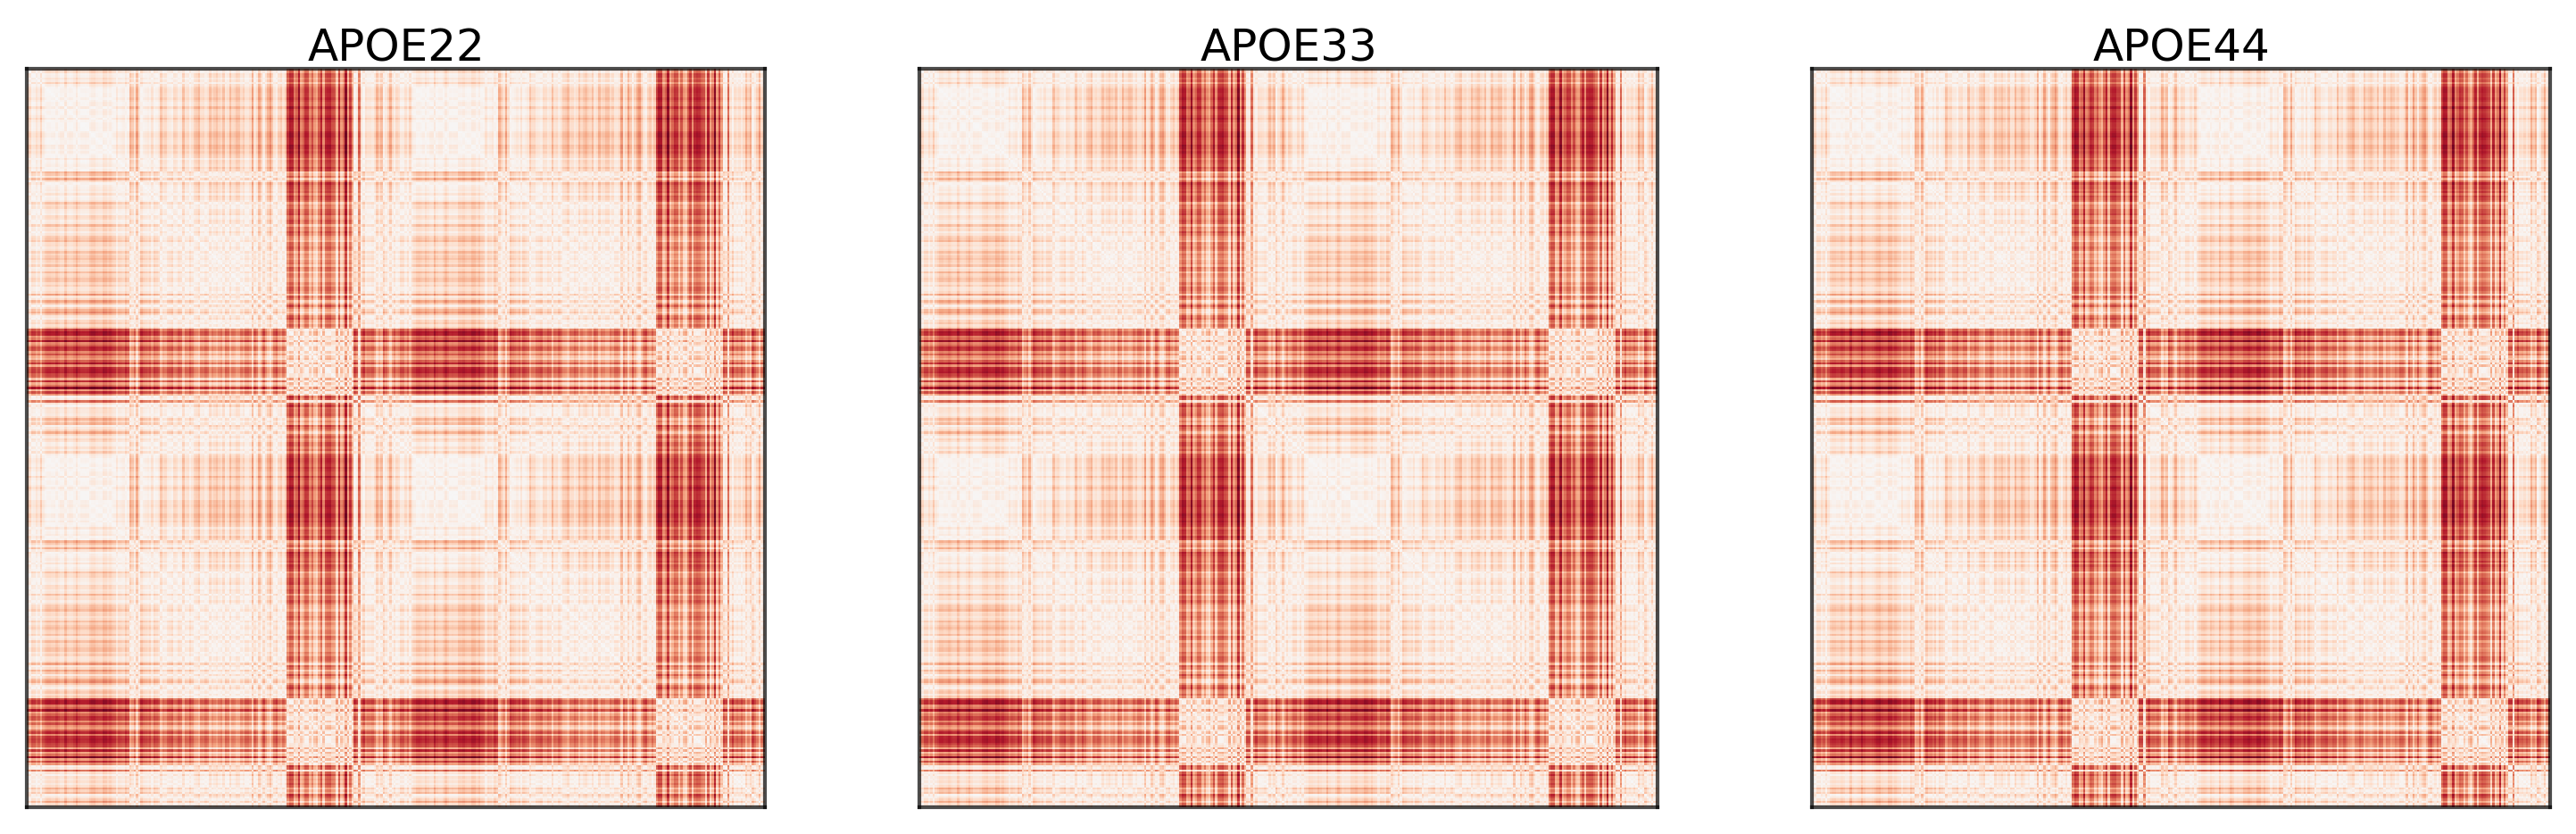

In [30]:
means = [fa_dists[labels == label].mean(axis=0) for label in np.unique(labels)]

## plot the mean differences per genotype
fig, ax = plt.subplots(
    ncols=3,
    figsize=(10, 3),
    constrained_layout=True,
    dpi=300,
    gridspec_kw=dict(width_ratios=[1, 1, 1]),
)

for idx, label in enumerate(np.unique(labels)):
    data = fa_dists[labels == label].mean(axis=0)
    gp.plot.adjplot(
        means[idx],
        ax=ax[idx],
        # meta=vertex_name,
        # group=["Hemisphere_abbrev"],
    )
    ax[idx].set_title(f"{label}", pad=0, size=12)

## Visualize the abolute differences in genotypes

Here take the absolute differences in the mean distance matrices, and visualize the resulting matrix. We now see that different pairs of genotypes show distinct patterns.

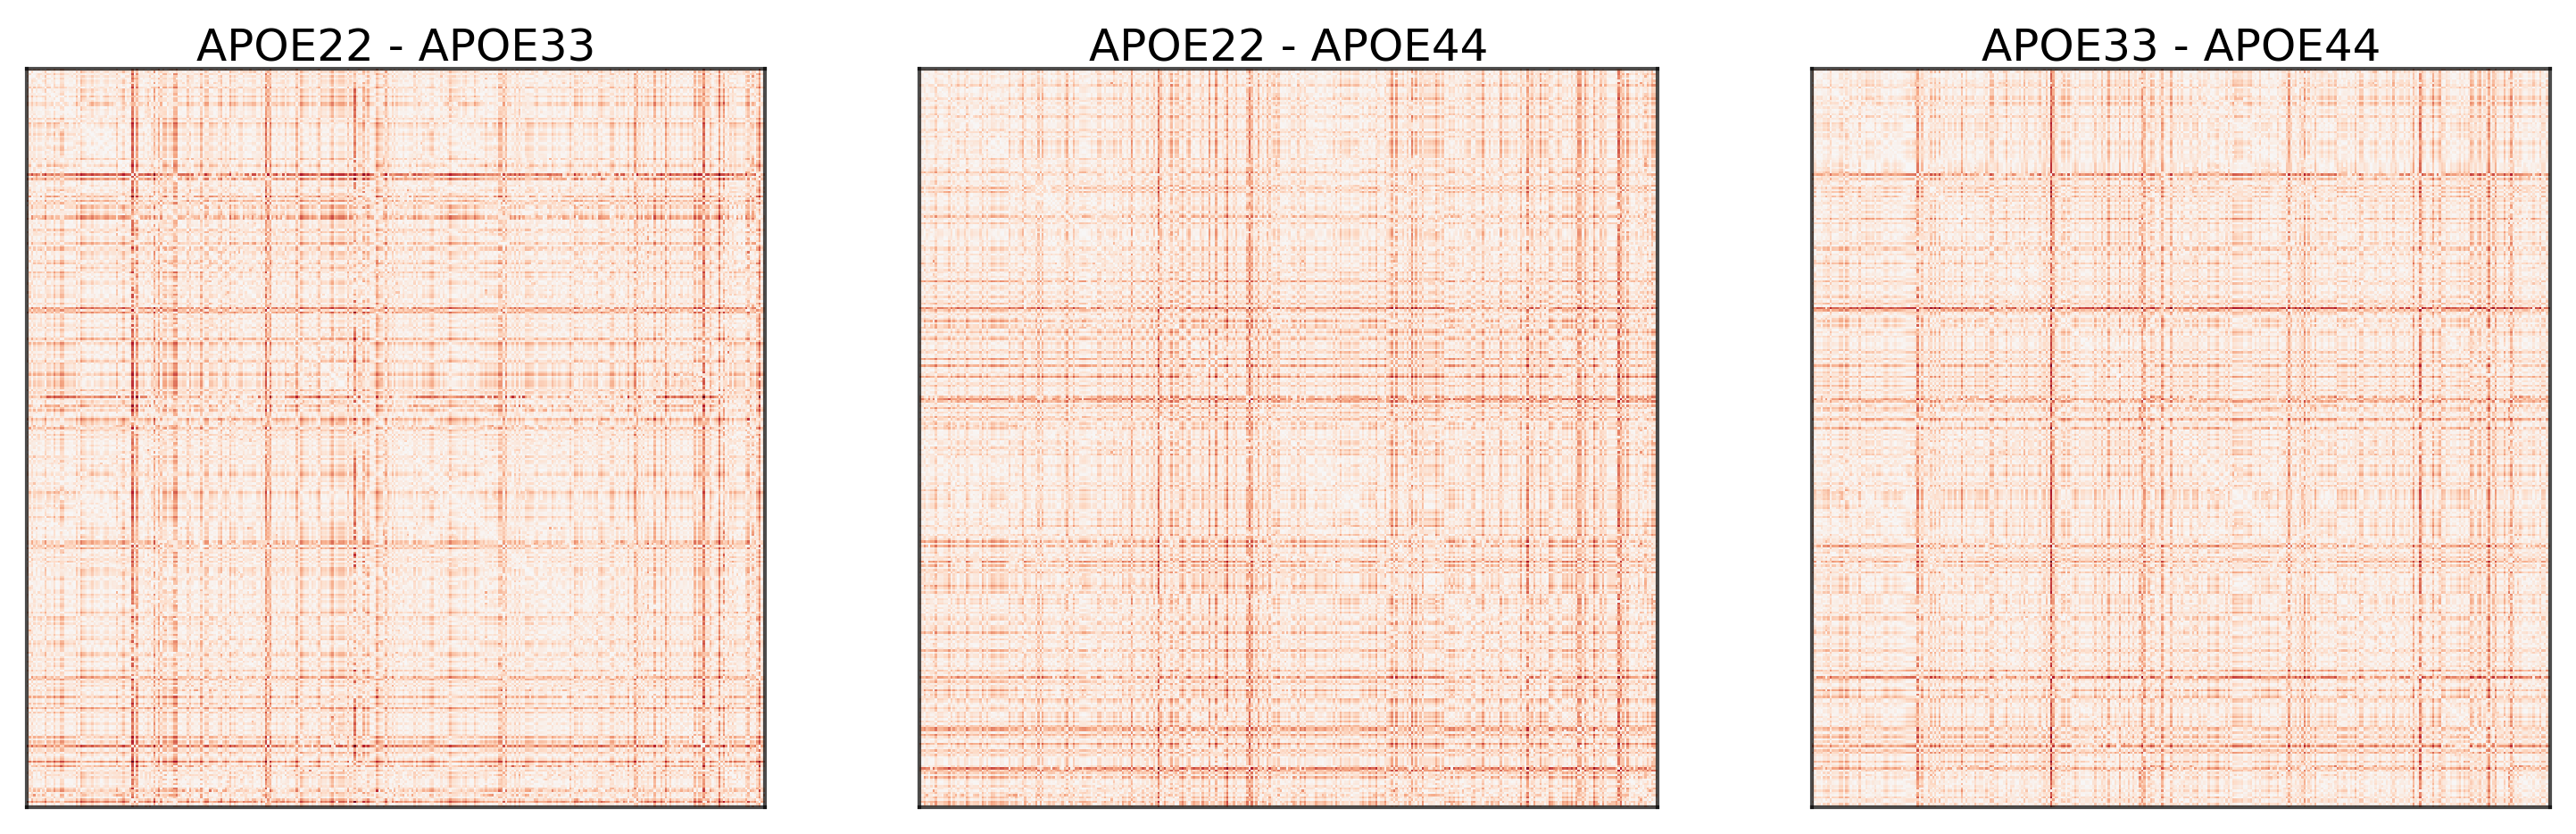

In [31]:
## plot the absolute difference in means
fig, ax = plt.subplots(
    ncols=3,
    figsize=(10, 3),
    constrained_layout=True,
    dpi=300,
    gridspec_kw=dict(width_ratios=[1, 1, 1]),
)

for idx, (label1, label2) in enumerate([(0, 1), (0, 2), (1, 2)]):
    data = np.abs(means[label1] - means[label2])
    gp.plot.adjplot(
        data,
        ax=ax[idx],
        # meta=vertex_name,
        # group=["Hemisphere_abbrev"],
    )
    ax[idx].set_title(
        f"{unique_labels[label1]} - {unique_labels[label2]}", pad=0, size=12
    )

## Edge-wise analysis of distances

In [52]:
rdx, cdx = np.triu_indices_from(fa_dists[0], k=1)
n = rdx.size

apoe2 = fa_dists[labels == "APOE22"]
apoe3 = fa_dists[labels == "APOE33"]
apoe4 = fa_dists[labels == "APOE44"]


def worker(x, y, z, reps=5000, auto=False):
    stat, pval = KSample("Dcorr").test(x, y, z, auto=auto, reps=reps)
    return stat, pval


res = Parallel(-1, verbose=0)(
    delayed(worker)(apoe2[:, i, j], apoe3[:, i, j], apoe4[:, i, j])
    for i, j in zip(rdx, cdx)
)

In [53]:
edge_df = pd.DataFrame(res, columns=["stat", "pvalue"])

edge_df["rdx"] = rdx
edge_df["cdx"] = cdx

for idx, row in edge_df.iterrows():
    loc1 = row["rdx"]
    region1 = vertex_df.loc[loc1, ["Hemisphere", "Structure"]]

    loc2 = row["cdx"]
    region2 = vertex_df.loc[loc2, ["Hemisphere", "Structure"]]

    edge_df.loc[idx, "region1"] = "-".join(region1.values)
    edge_df.loc[idx, "region2"] = "-".join(region2.values)

significant, corrected_pvalue, _, _ = multipletests(edge_df.pvalue, method="fdr_bh")

edge_df["corrected_pvalue"] = corrected_pvalue
edge_df["significant"] = significant

edge_df = edge_df[
    ["stat", "pvalue", "corrected_pvalue", "significant", "region1", "region2"]
]
edge_df.to_csv("../outs/fa_edge.csv", index=False)

In [158]:
edge_df.sort_values(["pvalue", "stat"], ascending=[True, False]).head(10)

,stat,pvalue,corrected_pvalue,significant,region1,region2
53084,0.512056,0.00005,0.032704,True,R-Raphe_Nucleus,R-Spinal_Trigeminal_Nerve
54456,0.494586,0.00005,0.032704,True,R-Spinal_Trigeminal_Nerve,R-Medial_Lemniscus
43300,0.472303,0.00005,0.032704,True,R-Dorsolateral_Orbital_Cortex,R-Cingulate_Cortex_Area_25
46672,0.460022,0.00005,0.032704,True,R-Primary_Visual_Cortex_Monocular_Area,R-Cingulate_Cortex_Area_25
9175,0.452144,0.00005,0.032704,True,L-Primary_Somatosensory_Cortex_Jaw_Region,R-Cingulate_Cortex_Area_25
1708,0.450266,0.00005,0.032704,True,L-Cingulate_Cortex_Area_29b,L-Anterior_Pretectal_Nucleus
40575,0.449442,0.00005,0.032704,True,L-IntermediateReticularNucleus,R-Cerebrospinal_fluid
23417,0.442129,0.00005,0.032704,True,L-Superior_Colliculus,R-Dorsolateral_Orbital_Cortex
8586,0.441193,0.00005,0.032704,True,L-Primary_Somatosensory_Cortex_Hindlimb_Region,L-Primary_Somatosensory_Cortex_Jaw_Region
38139,0.436460,0.00005,0.032704,True,L-Cingulate_Cortex_Area_25,R-Dorsolateral_Orbital_Cortex


In [159]:
edge_df.significant.sum()

993

The total number of significant pairs of regions are 993 out of 54946 pairs.

## Vertex-wise analysis of distances

In [89]:
res = Parallel(-1, verbose=0)(
    delayed(worker)(apoe2[:, i, :], apoe3[:, i, :], apoe4[:, i, :], reps=100000)
    for i in range(apoe2.shape[1])
)

region_df = pd.DataFrame(res, columns=["stat", "pvalue"])

region_df["idx"] = np.arange(apoe2.shape[1])

for idx, row in region_df.iterrows():
    loc = row["idx"]
    region = vertex_df.loc[loc, ["Hemisphere", "Structure"]]

    region_df.loc[idx, "region"] = "-".join(region.values)

significant, corrected_pvalue, _, _ = multipletests(region_df.pvalue, method="fdr_bh")
region_df["corrected_pvalue"] = corrected_pvalue
region_df["significant"] = significant

region_df = region_df[["stat", "pvalue", "corrected_pvalue", "significant", "region"]]

region_df.to_csv("../outs/fa_vertex.csv", index=False)

In [90]:
region_df.sort_values(["pvalue", "stat"], ascending=[True, False]).head(10)

,stat,pvalue,corrected_pvalue,significant,region
28,0.268610,0.00029,0.026892,True,L-Primary_Somatosensory_Cortex_Jaw_Region
314,0.324524,0.00032,0.026892,True,R-Cingulate_Cortex_Area_25
173,0.285267,0.00041,0.026892,True,R-Cingulate_Cortex_Area_30
72,0.234462,0.00047,0.026892,True,L-Ventral_Thalamic_Nuclei
157,0.295831,0.00059,0.026892,True,L-Red_Nucleus_Magnocellular
202,0.255369,0.00063,0.026892,True,R-Primary_Visual_Cortex_Monocular_Area
50,0.228251,0.00067,0.026892,True,L-Hippocampus
229,0.243990,0.00072,0.026892,True,R-Striatum
148,0.283246,0.00077,0.026892,True,L-Cingulate_Cortex_Area_25
270,0.281154,0.00081,0.026892,True,R-Raphe_Nucleus


In [91]:
(region_df.significant).sum()

59

The total number of significant regions is 59 out of 332 regions. 

# Comparing the results from volume distances and FA distances


To compare the results of volume and FA edge-wise analysis, we compute two measures:

1. Kendall's Tau, which measures the correspondence between two rankings. Values close to 1 indicate strong agreement, and values close to -1 indicate strong disagreement. We compute Kendall's Tau of the rankings of the test statistics.
2. Jaccard distance, which measures the distance between two boolean vectors. We compute the distance between the vectors containing whether the test was significant or not.

In [128]:
from scipy.spatial.distance import jaccard
from scipy.stats import kendalltau

In [127]:
vol_regions = pd.read_csv("../outs/volume_vertex.csv")
fa_regions = pd.read_csv("../outs/fa_vertex.csv")

vol_edge = pd.read_csv("../outs/volume_edge.csv")
fa_edge = pd.read_csv("../outs/fa_edge.csv")

## Edge-wise analysis of results

In [103]:
vol_edge_idx = np.argsort(-vol_edge.stat)
fa_edge_idx = np.argsort(-fa_edge.stat)

kendalltau(vol_edge_idx, fa_edge_idx)

SignificanceResult(statistic=-0.0014717900860659208, pvalue=0.6048229796699123)

In [129]:
jaccard(fa_edge.significant, vol_edge.significant)

0.9958799293702177

We get Kendall's Tau of -0.00147 and Jaccard distance of 0.996. This suggest that there is very little agreement between the test statistics and the region pairs that are significant. However, since the Jaccard's distance is not 1, there is some agreement. In the following, we look at pairs of regions that are signifcantly different from both the volume and FA analysis.

In [156]:
vol_edge_sig = vol_edge[vol_edge.significant == 1].index
fa_edge_sig = fa_edge[fa_edge.significant == 1].index

print(vol_edge.iloc[np.intersect1d(vol_edge_sig, fa_edge_sig)][["region1", "region2"]])

                                 region1                            region2
4323             L-Frontal_Cortex_Area_3  L-Pontine_Reticular_NucleusCaudal
18943                         L-Striatum                L-Tegmental_Nucleus
18993                         L-Striatum        L-Red_Nucleus_Magnocellular
19106                         L-Striatum                    R-Raphe_Nucleus
29768                L-Tegmental_Nucleus             L-Posterior_Commissure
30998  L-Pontine_Reticular_NucleusCaudal          R-Interpeduncular_Nucleus
34821             L-Posterior_Commissure                 R-Medial_Lemniscus


## Vertex wise analysis of results

In [143]:
vol_regions_idx = np.argsort(-vol_regions.stat)
fa_regions_idx = np.argsort(-fa_regions.stat)

kendalltau(vol_regions_idx, fa_regions_idx)

SignificanceResult(statistic=-0.007097877916499838, pvalue=0.8469772553058393)

In [144]:
jaccard(vol_regions.significant, fa_regions.significant)

0.8478260869565217

We get Kendall's Tau of -0.007 and Jaccard distance of 0.848. This suggest that there is very little agreement between the test statistics and the region pairs that are significant. However, since the Jaccard's distance is not 1, there is some agreement. In the following, we look at regions that are signifcantly different from both the volume and FA analysis.

In [154]:
vol_regions_sig = vol_regions[vol_regions.significant == 1].index
fa_regions_sig = fa_regions[fa_regions.significant == 1].index

print(fa_regions.iloc[np.intersect1d(vol_regions_sig, fa_regions_sig)].region)

8                             L-Cingulate_Cortex_Area_32
13                               L-Frontal_Cortex_Area_3
24           L-Primary_Somatosensory_Cortex_Barrel_Field
25       L-Primary_Somatosensory_Cortex_Dysgranular_Zone
28             L-Primary_Somatosensory_Cortex_Jaw_Region
34                               L-Primary_Visual_Cortex
66                 L-Bed_Nucleus_of_the_Stria_Terminalis
68                                 L-Periaquaductal_Grey
83                           L-Red_Nucleus_Parvicellular
87                                L-Precuneiform_Nucleus
98     L-Parvicellular_Reticular_Nucleus_and_Principa...
105                         L-Trigeminal_Sensory_Nucleus
106                                   L-Dorsal_Tegmentum
107                                  L-Tegmental_Nucleus
142                      L-Ventral_Spinocerebellar_Tract
148                           L-Cingulate_Cortex_Area_25
152                    L-Microcellular_Tegmental_Nucleus
157                          L-

In [161]:
np.intersect1d(vol_regions_sig, fa_regions_sig).size

42